# Exploratory Data Analysis
### KirbyDownB
During this phase, we'll be performing EDA on the data we've collected. As of now, we have restaurant data from Yelp, along with income data based on zip code, which we scraped.

## Install Packages

In [1]:
!pip3 install pymongo nltk wordcloud textblob numpy

## Import Packages

In [6]:
from pymongo import MongoClient
from scripts.constants import mongodb_atlas_connection
from scripts.helpers import isZipCodeValid
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import nltk
import pandas as pd
import numpy as np
import re

nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/ericong18/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ericong18/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Fetch Data

All of our data is stored in a MongoDB Atlas cluster, so we need to connect to the cluster first and retrieve the necessary data.

In [8]:
client = MongoClient(mongodb_atlas_connection)

yelp_db = client['yelp']
income_db = client['income']

restaurants_collection = yelp_db['restaurants_new']
reviews_collection = yelp_db['reviews']
zip_code_collection = income_db['zipcode']

zip_codes = list(zip_code_collection.find())
zip_restaurants = list(restaurants_collection.find())
reviews = list(reviews_collection.find())

client.close()

## Data Cleaning/Massaging

The zip codes we scraped are obviously not 100% clean and perfect. Thus, we need to filter out the zip codes that are usable, thanks to a helper function we wrote.

In [9]:
zip_codes = list(filter(lambda x: isZipCodeValid(x['zip']), zip_codes))

The Yelp Fusion API was able to give us 3 review excerpts per restaurant. Using these reviews, we'd like to extract their sentiment score, which we'll use for EDA below and our ML portion.

In [11]:
stop_words = stopwords.words('english')
rest_review = {}

for review in reviews:
    polarity = 0
    subjectivity = 0
    review_count = 0
    rid = review['rid']
    rName = review['name']    
    
    for i in review['reviews']:
        pre_process = i['text'].lower()
        pre_process = re.sub('[^a-z0-9]+', ' ', pre_process)
        pre_process = word_tokenize(pre_process)
        pre_process = [w for w in pre_process if not w in stop_words] 
        temp = list(TextBlob(' '.join(pre_process)).sentiment)
        polarity += temp[0]
        subjectivity += temp[0]
        review_count += 1
    
    polarity = polarity/review_count 
    subjectivity = subjectivity/review_count
    rest_review[rid] = [polarity, subjectivity]

To help with constructing a DataFrame, we need to create 2 mappings: restaurant ID to it's corresponding zip code and restaurant ID to it's rating on Yelp.

In [15]:
rest_zip_code = {}
rest_ratings = {}

for zip_restaurant in zip_restaurants:
    restaurants = zip_restaurant['restaurants']
    zip_code = zip_restaurant['zipcode']
    
    for restaurant in restaurants:
        rid = restaurant['id']
        rating = restaurant['rating']
        rest_zip_code[rid] = zip_code
        rest_ratings[rid] = rating

Another mapping we need to create is zip code to the income for that zip code.

In [16]:
zip_income = {}

for obj in zip_codes:
    zip_code = obj['zip']
    income = obj['income']
    zip_income[zip_code] = income

Finally, we can prepare the data we massaged to be inserted into a data frame, thanks to the necessary mappings we created.

In [17]:
labels = ['id', 'restaurant_id', 'restaurant_name', 'zip_code', 'avg_sentiment_polarity', 'avg_sentiment_subjectivity', 'zip_code_income', 'restaurant_rating']

data = []
for index, obj in enumerate(reviews):
    restaurant_id = obj['rid']
    restaurant_name = obj['name']
    
    if restaurant_id not in rest_zip_code:
        continue
    zip_code = rest_zip_code[restaurant_id]
    
    sentiment_polarity = np.nan
    sentiment_subjectivity = np.nan
    
    if restaurant_id in rest_review:
        sentiment = rest_review[restaurant_id]
        sentiment_polarity = sentiment[0]
        sentiment_subjectivity = sentiment[1]
    
    zip_code_income = zip_income[zip_code]
    restaurant_rating = rest_ratings[restaurant_id]
    
    value = [index, restaurant_id, restaurant_name, zip_code, sentiment_polarity, sentiment_subjectivity, zip_code_income, restaurant_rating]
    data.append(value)

Now, let's look at what our data frame looks like

In [18]:
df = pd.DataFrame(data, columns=labels)
df.set_index('id', inplace=True)
df.head()

,restaurant_id,restaurant_name,zip_code,avg_sentiment_polarity,avg_sentiment_subjectivity,zip_code_income,restaurant_rating
id,,,,,,,
0,vjGFXOzI1TCLYnnYYjxiXg,Market Restaurant + Bar,92007,0.038889,0.038889,"$62,877.00",4.5
1,gxwEOjyhbMYCBSQ7tB7aNw,"Snooze, An A.M. Eatery",92075,0.341270,0.341270,"$69,057.00",4.0
2,ULJp8Bc_7iLHNz6Xzi2eRw,Thyme In The Ranch,92091,0.484821,0.484821,"$103,904.00",4.0
3,3yQtkLcDAqMVX5oNYHyJhA,Claire's On Cedros,92007,0.311806,0.311806,"$62,877.00",4.0
4,Sc3Mpf7ei8CS8PW7HD2k6w,Mille Fleurs,92091,0.322159,0.322159,"$103,904.00",4.0


The 'zip_code_income' column isn't properly formatted as a float type, so let's go ahead and fix that.

In [19]:
df['zip_code_income'] = df['zip_code_income'].str.replace(',','').str.replace('$','').astype('float')
df.head()

,restaurant_id,restaurant_name,zip_code,avg_sentiment_polarity,avg_sentiment_subjectivity,zip_code_income,restaurant_rating
id,,,,,,,
0,vjGFXOzI1TCLYnnYYjxiXg,Market Restaurant + Bar,92007,0.038889,0.038889,62877.0,4.5
1,gxwEOjyhbMYCBSQ7tB7aNw,"Snooze, An A.M. Eatery",92075,0.341270,0.341270,69057.0,4.0
2,ULJp8Bc_7iLHNz6Xzi2eRw,Thyme In The Ranch,92091,0.484821,0.484821,103904.0,4.0
3,3yQtkLcDAqMVX5oNYHyJhA,Claire's On Cedros,92007,0.311806,0.311806,62877.0,4.0
4,Sc3Mpf7ei8CS8PW7HD2k6w,Mille Fleurs,92091,0.322159,0.322159,103904.0,4.0


zip_code
90002    4.428571
90003    4.555556
90004    4.500000
90005    4.303571
90008    4.375000
90011    4.055556
90016    4.250000
90018    4.500000
90022    4.666667
90023    4.500000
90024    4.000000
90025    4.000000
90026    4.000000
90027    3.500000
90028    4.272727
90029    4.312500
90031    4.375000
90032    4.600000
90033    4.136364
90034    4.166667
90035    4.125000
90038    4.000000
90044    4.412500
90045    4.000000
90046    4.166667
90047    4.500000
90059    4.300000
90061    4.500000
90062    4.200000
90063    4.250000
           ...   
96054    4.380000
96058    4.035714
96059    3.666667
96063    4.333333
96071    3.884615
96074    4.400000
96075    3.964286
96076    4.323529
96086    4.000000
96090    4.266667
96091    4.333333
96092    4.250000
96093    4.500000
96094    4.250000
96105    4.500000
96106    4.333333
96107    4.312500
96109    3.750000
96115    4.666667
96118    4.500000
96123    4.400000
96125    3.750000
96133    4.166667
96134    4.500000
9

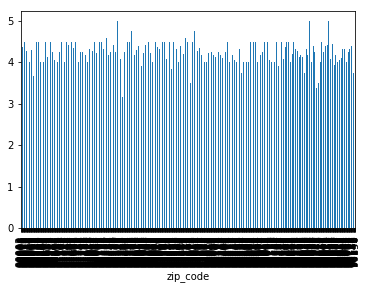

In [21]:
%matplotlib inline
df.groupby('zip_code')['restaurant_rating'].mean().plot.bar()
df.groupby('zip_code')['restaurant_rating'].mean()

## Histogram

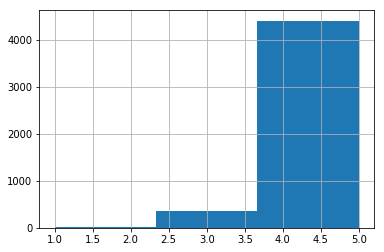

In [22]:
# histogram
df.restaurant_rating.hist(bins=3)

As we can see, most of the ratings fall between 4 and 5 stars

## Boxplots

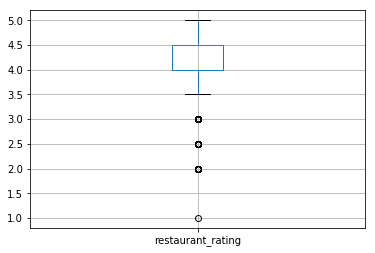

In [23]:
 df.boxplot(column=['restaurant_rating'])

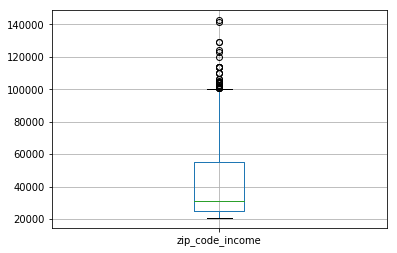

In [24]:
 df.boxplot(column=['zip_code_income'])

The restaurant data seems to have a few outliers, and it is interesting to note that all of the outliers are on the lower end. This is the opposite of the income data, where all ofthe outliers are on the higher end.

## Scatter Plots

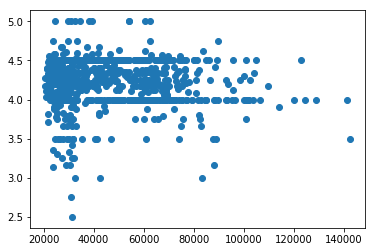

In [25]:
import matplotlib.pyplot as plt

series = df.groupby('zip_code_income')['restaurant_rating'].mean()
import pylab
pylab.scatter(series.index, series)

Although there is not a clear correlation we can make with the data, we can at least notice a few trends. While restaurants that are in the lower income range are all over the place, the restaurants in the higher income areas tend to have a more stable rating.

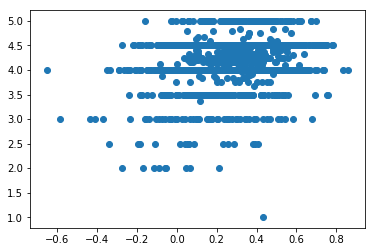

In [26]:
series = df.groupby('avg_sentiment_subjectivity')['restaurant_rating'].mean()
pylab.scatter(series.index, series)

It also seems, from the above data, at least, that the reviews themselves are not a good indicator for whether the rating of the restaurant itself will be good as well. One would think that a restaurant with more favorable reviews would result in a higher average rating. 

In [ ]:
df.plot.scatter(x='zip_code_income',y='avg_sentiment_subjectivity')
# pylab.scatter(series.index, series)

Similar to the comparison with rating and the review sentiment, we see that in areas with a lower median income, the reviews tend to be more wide ranging, with sentiment ranging from -0.6 all the way to 0.8 in areas with a median income of $20,000, while in wealthier areas, the reviews tend to be much more consolidated. 

## Conclusion

Although we didn't find any clear positive or negative correlation between some of the datapoint as we were expecting, we still found some interesting trends in the data. The most ineresting insighty we foiund was that the sentiment of the ratijngs themselves don't necessarily correspond to the ratings. That is, the number of stars someone gives a restaurant is not a clear indicator of how well they will review the restaurant, which makes sense. People may use the same words to describe a similar experience, but their overall sentiment may be very different,as these things are influenced by many other factors.

Another trend we indentified was that ratings in areas with a lower median income area tended to be all over the place, while ratings from areas with a higher median income, both in the actual rating and the sentiments of the reviews, tended to be significantly more stable.

## Exporting Data

The data frame we created will be used in our ML portion of the project. Let's export it so we can use it in the notebook where we'll be exploring different ML techniques we can use on our data.

In [ ]:
df.to_csv('data.csv', index=False)